In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [40]:
train_df = pd.read_csv('Train_Data (1).csv')
test_df = pd.read_csv('Test_Data (1).csv')
# sample_submission = pd.read_csv('Sample_Submission.csv')

In [5]:
train_df.shape

(1966, 9)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1966 entries, 0 to 1965
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SEQN       1954 non-null   float64
 1   RIAGENDR   1948 non-null   float64
 2   PAQ605     1953 non-null   float64
 3   BMXBMI     1948 non-null   float64
 4   LBXGLU     1953 non-null   float64
 5   DIQ010     1948 non-null   float64
 6   LBXGLT     1955 non-null   float64
 7   LBXIN      1957 non-null   float64
 8   age_group  1952 non-null   object 
dtypes: float64(8), object(1)
memory usage: 138.4+ KB


In [7]:
train_df.isnull().sum()

SEQN         12
RIAGENDR     18
PAQ605       13
BMXBMI       18
LBXGLU       13
DIQ010       18
LBXGLT       11
LBXIN         9
age_group    14
dtype: int64

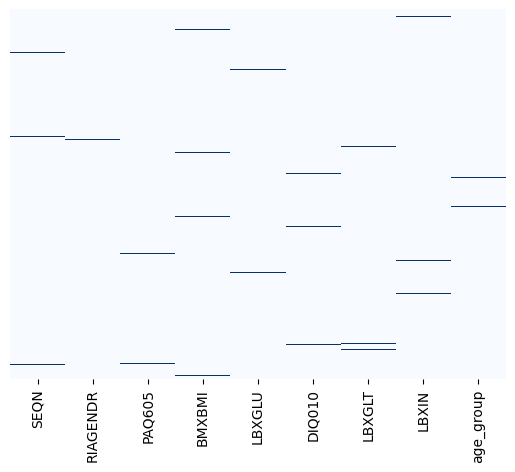

In [8]:
sns.heatmap(train_df.isnull(), cmap='Blues', cbar=False, yticklabels=False, xticklabels=train_df.columns);

In [9]:
train_df = train_df[train_df['age_group'].isin(['Adult', 'Senior'])].copy()
train_df['age_group'] = train_df['age_group'].map({'Adult': 0, 'Senior': 1})

# Separate target
y_train = train_df['age_group']
X_train = train_df.drop(columns=['age_group'])

# Impute missing values
imputer = KNNImputer(n_neighbors=5)
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(test_df), columns=test_df.columns)

# Add target back to train
X_train_imputed['age_group'] = y_train.values

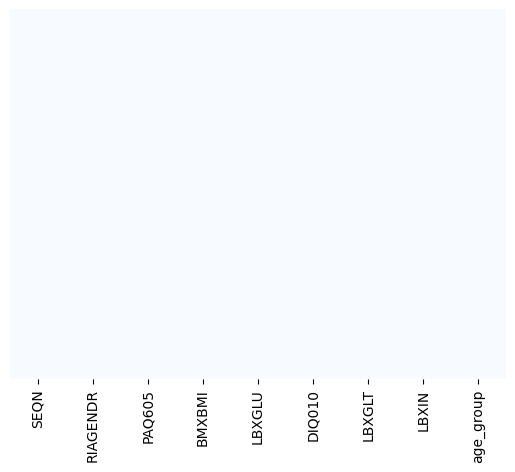

In [10]:
sns.heatmap(X_train_imputed.isnull(), cmap='Blues', cbar=False, yticklabels=False, xticklabels=train_df.columns);

In [11]:
for df in [X_train_imputed, X_test_imputed]:
    df['IS_FEMALE'] = (df['RIAGENDR'] == 2).astype(int)

    def bmi_category(bmi):
        if bmi < 18.5:
            return 0
        elif bmi < 25:
            return 1
        elif bmi < 30:
            return 2
        else:
            return 3
    df['BMI_Category_Ordinal'] = df['BMXBMI'].apply(bmi_category)

    df['HIGH_GLUCOSE'] = (df['LBXGLU'] > 126).astype(int)
    df['GLU_INSULIN_RATIO'] = df['LBXGLU'] / (df['LBXIN'] + 1e-5)
    df['INSULIN_RESISTANT'] = (df['GLU_INSULIN_RATIO'] > 10).astype(int)
    df['PHYSICALLY_ACTIVE'] = (df['PAQ605'] == 1).astype(int)
    df['RISK_SCORE'] = 0.3 * df['BMXBMI'] + 0.4 * df['LBXGLU'] + 0.3 * df['IS_FEMALE']
    df['LOG_LBXIN'] = np.log1p(df['LBXIN'])
    df['LOG_GLU_INSULIN_RATIO'] = np.log1p(df['GLU_INSULIN_RATIO'])

In [12]:
numeric_cols = ['BMXBMI', 'LBXGLU', 'LBXIN','PAQ605','DIQ010', 'GLU_INSULIN_RATIO', 'RISK_SCORE']

def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower) | (data[column] > upper)]
    return outliers

# Print number of outliers for each numeric feature
for col in numeric_cols:
    outliers = detect_outliers_iqr(X_train_imputed, col)
    print(f'{col}: {len(outliers)} outliers')

BMXBMI: 75 outliers
LBXGLU: 89 outliers
LBXIN: 129 outliers
PAQ605: 351 outliers
DIQ010: 71 outliers
GLU_INSULIN_RATIO: 100 outliers
RISK_SCORE: 75 outliers


In [13]:
X_train_imputed['LOG_LBXIN'] = np.log1p(X_train_imputed['LBXIN'])  # log(1 + x)
X_train_imputed['LOG_GLU_INSULIN_RATIO'] = np.log1p(X_train_imputed['GLU_INSULIN_RATIO'])
X_test_imputed['LOG_LBXIN'] = np.log1p(X_test_imputed['LBXIN'])  # log(1 + x)
X_test_imputed['LOG_GLU_INSULIN_RATIO'] = np.log1p(X_test_imputed['GLU_INSULIN_RATIO'])

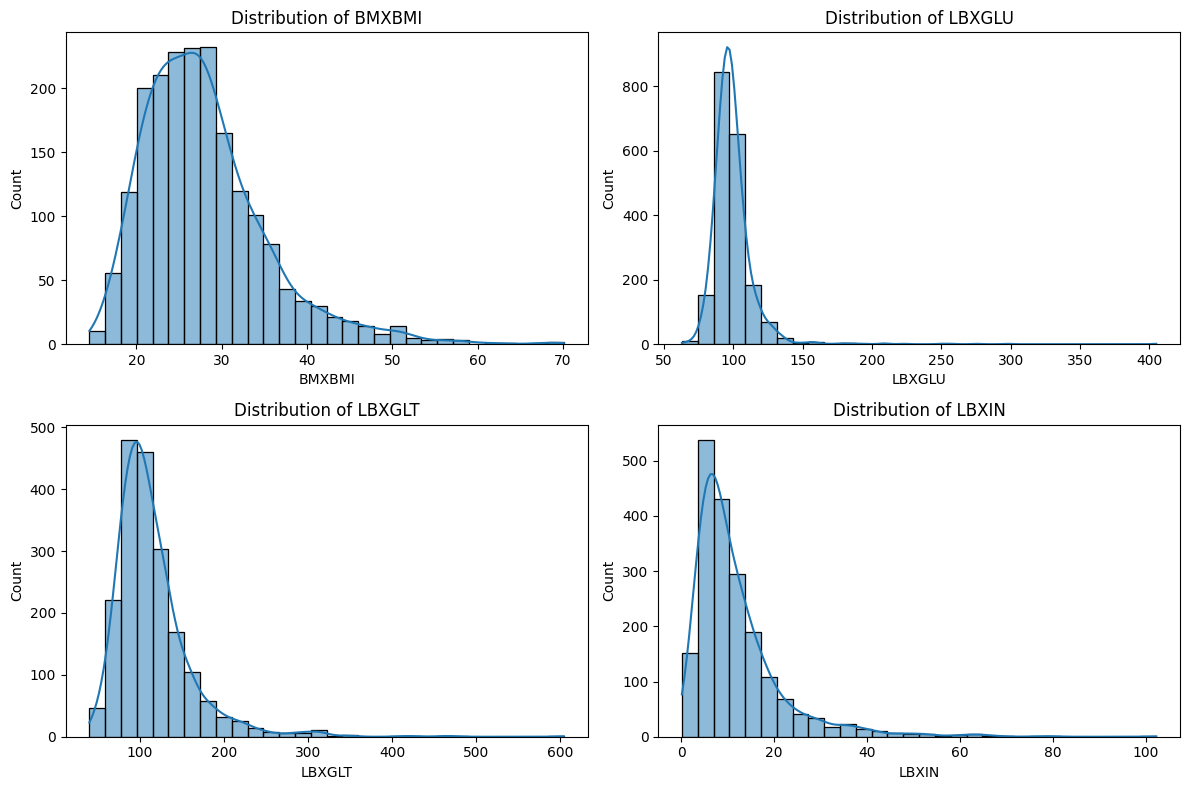

In [14]:
num_cols = ['BMXBMI', 'LBXGLU', 'LBXGLT', 'LBXIN']

plt.figure(figsize=(12, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(X_train_imputed[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

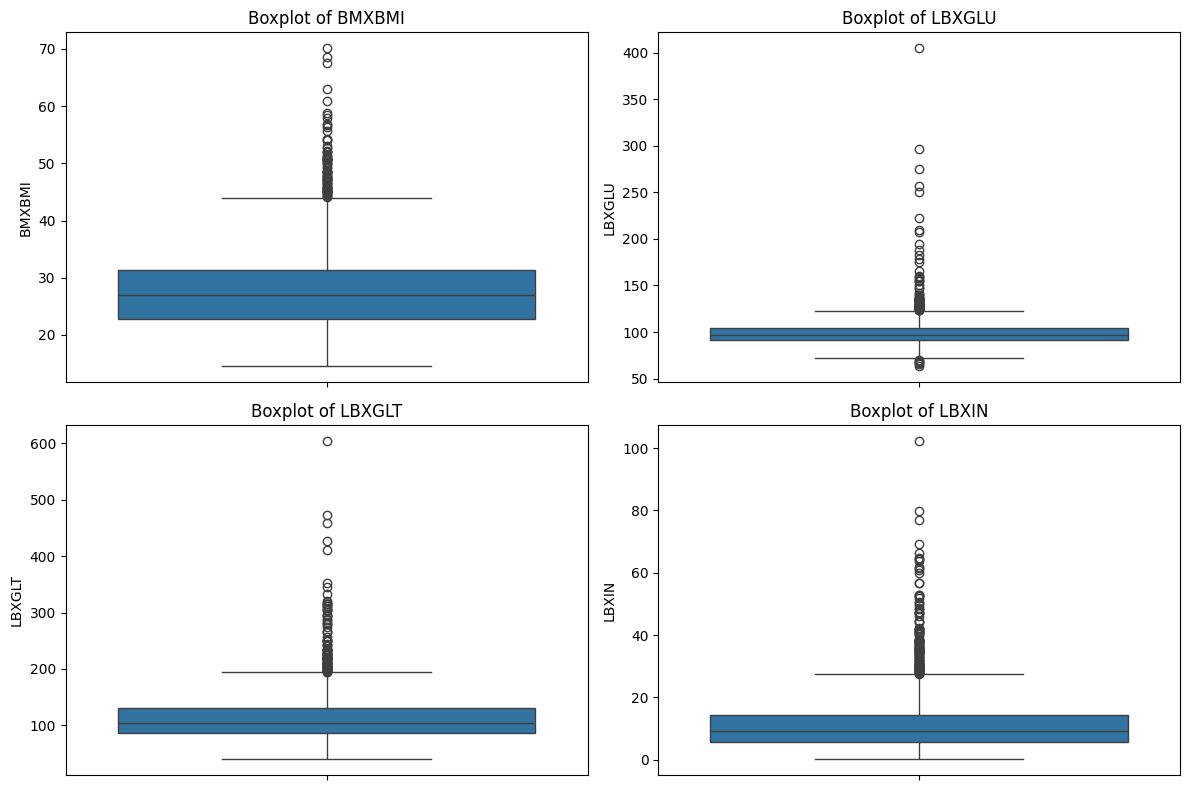

In [15]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=X_train_imputed[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

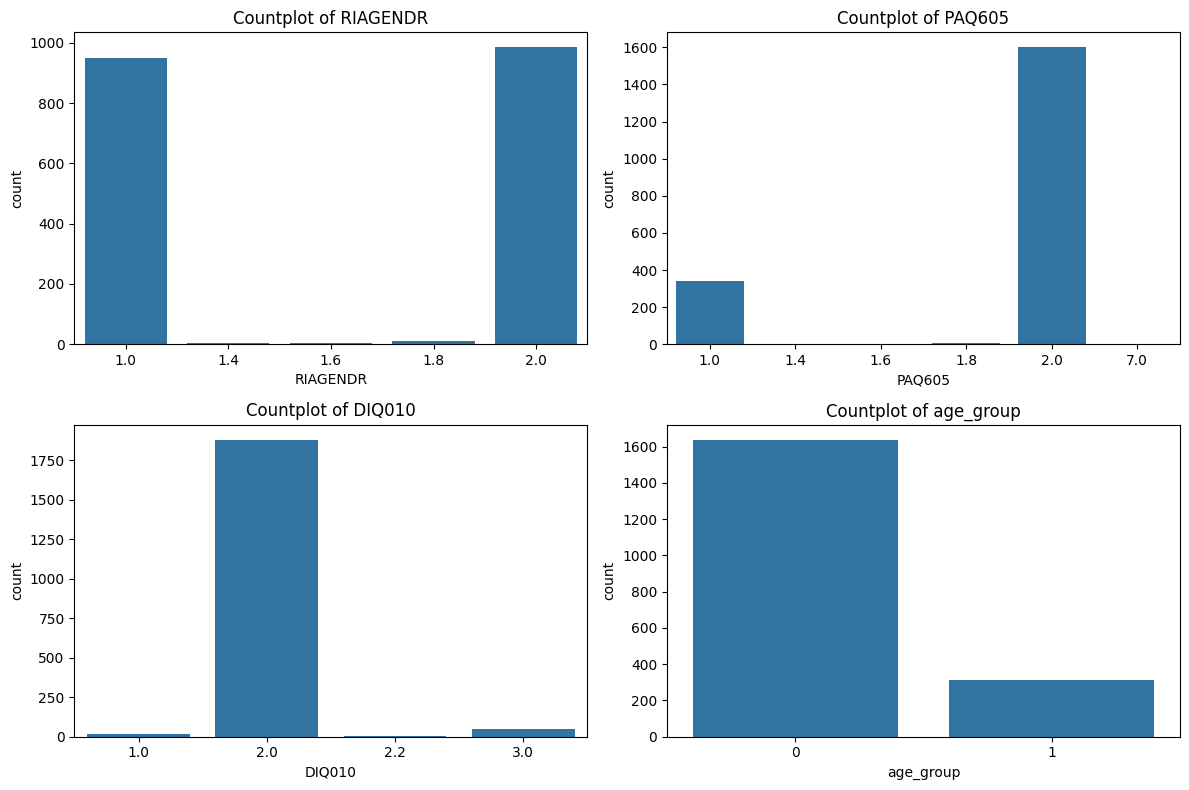

In [16]:
cat_cols = ['RIAGENDR', 'PAQ605', 'DIQ010', 'age_group']

plt.figure(figsize=(12, 8))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=X_train_imputed[col])
    plt.title(f'Countplot of {col}')
plt.tight_layout()
plt.show()

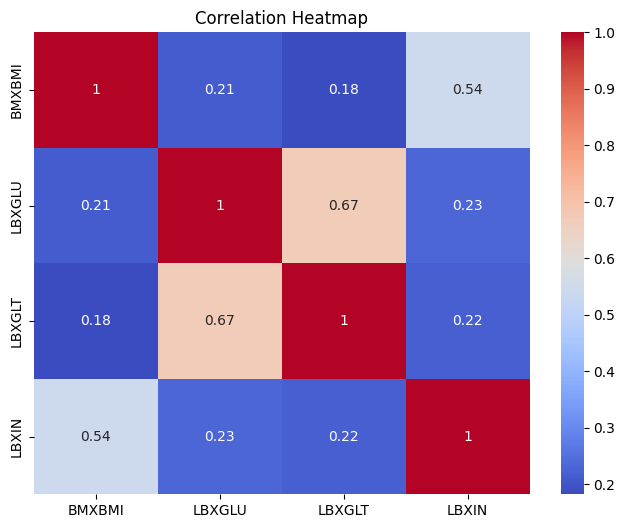

In [17]:
corr_cols = ['BMXBMI', 'LBXGLU', 'LBXGLT', 'LBXIN']
plt.figure(figsize=(8, 6))
sns.heatmap(X_train_imputed[corr_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


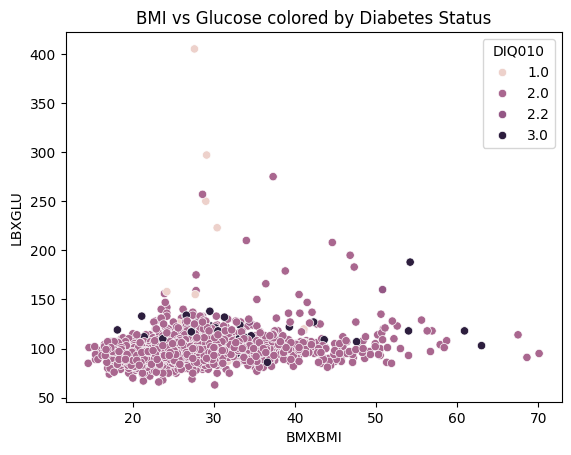

In [18]:
sns.scatterplot(data=X_train_imputed, x='BMXBMI', y='LBXGLU', hue='DIQ010')
plt.title('BMI vs Glucose colored by Diabetes Status')
plt.show()

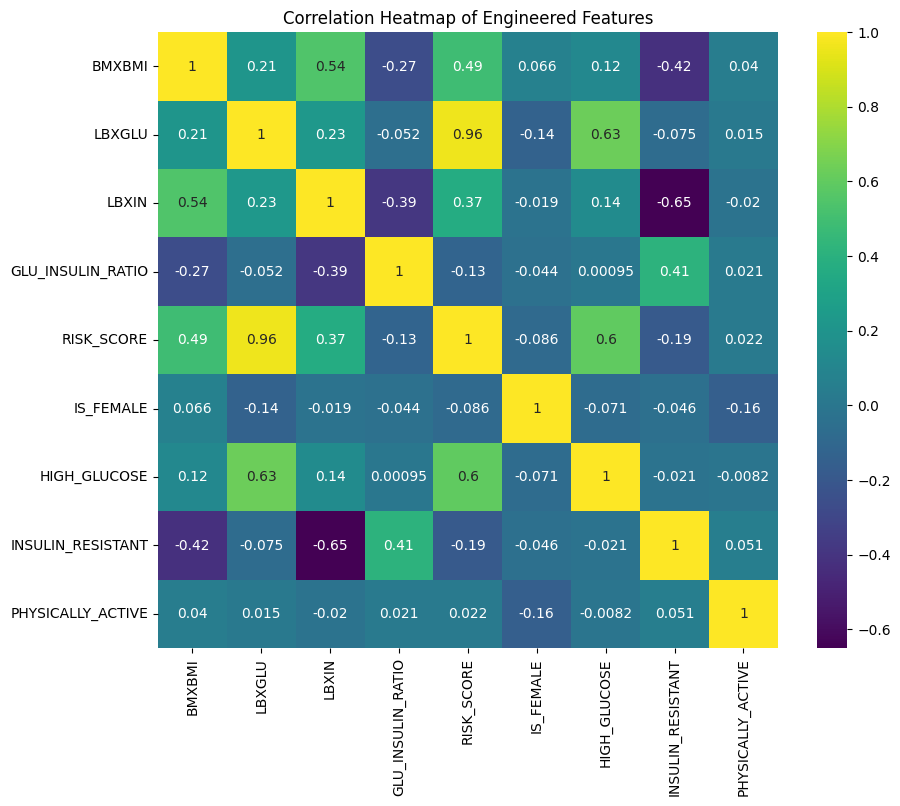

In [19]:
features_to_check = [
    'BMXBMI', 'LBXGLU', 'LBXIN', 'GLU_INSULIN_RATIO', 'RISK_SCORE',
    'IS_FEMALE', 'HIGH_GLUCOSE', 'INSULIN_RESISTANT', 'PHYSICALLY_ACTIVE'
]

plt.figure(figsize=(10, 8))
sns.heatmap(X_train_imputed[features_to_check].corr(), annot=True, cmap='viridis')
plt.title("Correlation Heatmap of Engineered Features")
plt.show()

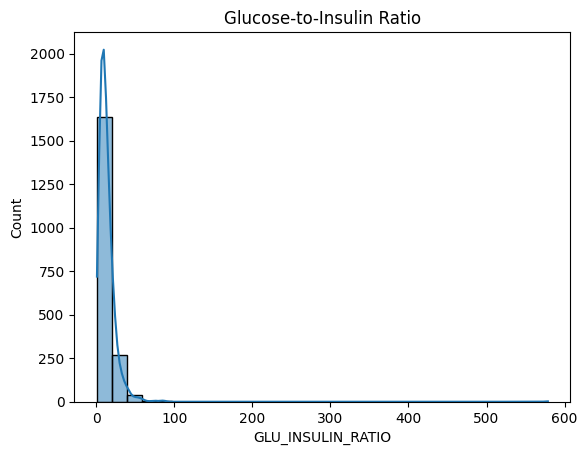

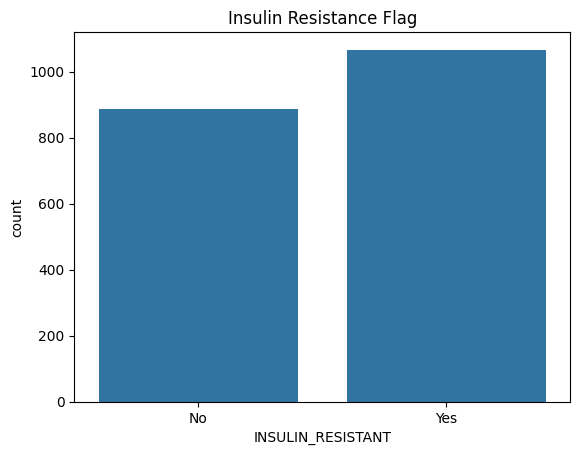

In [30]:
sns.histplot(X_train_imputed['GLU_INSULIN_RATIO'], kde=True, bins=30)
plt.title('Glucose-to-Insulin Ratio')
plt.show()

# Count of insulin resistance
sns.countplot(x='INSULIN_RESISTANT', data=X_train_imputed)
plt.title('Insulin Resistance Flag')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

In [31]:
features = [
    'RIAGENDR', 'PAQ605', 'BMXBMI', 'LBXGLU', 'DIQ010', 'LBXGLT', 'LOG_LBXIN',
    'IS_FEMALE', 'BMI_Category_Ordinal', 'HIGH_GLUCOSE', 'GLU_INSULIN_RATIO',
    'INSULIN_RESISTANT', 'PHYSICALLY_ACTIVE', 'RISK_SCORE', 'LOG_GLU_INSULIN_RATIO'
]

# Prepare final X and y
X_train_final = X_train_imputed[features]
y_train_final = X_train_imputed['age_group'].astype(int)
X_test_final = X_test_imputed[features]

In [32]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_final), columns=features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_final), columns=features)

In [33]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train_scaled, y_train_final, test_size=0.2, stratify=y_train_final, random_state=42)

In [34]:
model_scores = {}
best_models = {}

In [46]:
lr_params = {
    'C': [0.1, 1, 10],
    'solver': ['lbfgs', 'saga']
}
lr_grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), lr_params, cv=3, scoring='accuracy', n_jobs=-1)
lr_grid.fit(X_tr, y_tr)
lr_preds = lr_grid.predict(X_val)
model_scores['Logistic Regression'] = accuracy_score(y_val, lr_preds)
best_models['Logistic Regression'] = lr_grid.best_estimator_
print("\nLogistic Regression")
print("Best Params:", lr_grid.best_params_)
print("Accuracy:", model_scores['Logistic Regression'])


Logistic Regression
Best Params: {'C': 10, 'solver': 'lbfgs'}
Accuracy: 0.8312020460358056


In [47]:
from sklearn.svm import SVC
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear']
}
svm_grid = GridSearchCV(SVC(probability=True, random_state=42), svm_params, cv=3, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_tr, y_tr)
svm_preds = svm_grid.predict(X_val)
model_scores['SVM'] = accuracy_score(y_val, svm_preds)
best_models['SVM'] = svm_grid.best_estimator_
print("\nSVM")
print("Best Params:", svm_grid.best_params_)
print("Accuracy:", model_scores['SVM'])


SVM
Best Params: {'C': 0.1, 'kernel': 'rbf'}
Accuracy: 0.8388746803069054


In [48]:
best_model_name = max(model_scores, key=model_scores.get)
print(f"\n✅ Best Model: {best_model_name} with Accuracy: {model_scores[best_model_name]:.4f}")
best_model = best_models[best_model_name]


✅ Best Model: SVM with Accuracy: 0.8389


In [49]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tr, y_tr)

svm_grid.fit(X_resampled, y_resampled)
svm_preds = svm_grid.predict(X_val)
model_scores['SVM'] = accuracy_score(y_val, svm_preds)
best_models['SVM'] = svm_grid.best_estimator_

print("\nSVM")
print("Best Params:", svm_grid.best_params_)
print("Accuracy:", model_scores['SVM'])

best_model_name = max(model_scores, key=model_scores.get)
print(f"\n✅ Best Model: {best_model_name} with Accuracy: {model_scores[best_model_name]:.4f}")
best_model = best_models[best_model_name]

test_preds_encoded = best_model.predict(X_test_scaled)

print("Predicted class distribution in test set:")
print(pd.Series(test_preds_encoded).value_counts())

submission = pd.DataFrame({'age_group': test_preds_encoded})
submission.to_csv('submission.csv', index=False)
print("✅ Submission file 'submission.csv' created successfully!")



SVM
Best Params: {'C': 10, 'kernel': 'rbf'}
Accuracy: 0.6930946291560103

✅ Best Model: Logistic Regression with Accuracy: 0.8312
Predicted class distribution in test set:
0    297
1     15
Name: count, dtype: int64
✅ Submission file 'submission.csv' created successfully!


In [50]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tr, y_tr)

model_scores = {}
best_models = {}

# --- SVM ---
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear']
}
svm_grid = GridSearchCV(SVC(probability=True, random_state=42), svm_params, cv=3, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_resampled, y_resampled)
svm_preds = svm_grid.predict(X_val)
model_scores['SVM'] = accuracy_score(y_val, svm_preds)
best_models['SVM'] = svm_grid.best_estimator_

# --- Random Forest ---
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_resampled, y_resampled)
rf_preds = rf_grid.predict(X_val)
model_scores['RandomForest'] = accuracy_score(y_val, rf_preds)
best_models['RandomForest'] = rf_grid.best_estimator_

# --- Logistic Regression ---
lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear']
}
lr_grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), lr_params, cv=3, scoring='accuracy', n_jobs=-1)
lr_grid.fit(X_resampled, y_resampled)
lr_preds = lr_grid.predict(X_val)
model_scores['LogisticRegression'] = accuracy_score(y_val, lr_preds)
best_models['LogisticRegression'] = lr_grid.best_estimator_

# --- Voting Classifier ---
voting_clf = VotingClassifier(estimators=[
    ('svm', svm_grid.best_estimator_),
    ('rf', rf_grid.best_estimator_),
    ('lr', lr_grid.best_estimator_)
], voting='soft')

voting_clf.fit(X_resampled, y_resampled)
voting_preds = voting_clf.predict(X_val)
model_scores['Voting'] = accuracy_score(y_val, voting_preds)
best_models['Voting'] = voting_clf

# --- Select Best Model ---
best_model_name = max(model_scores, key=model_scores.get)
best_model = best_models[best_model_name]

print(f"\n✅ Best Model: {best_model_name} with Accuracy: {model_scores[best_model_name]:.4f}")

# --- Predict on Test Set ---
test_preds_encoded = best_model.predict(X_test_scaled)
print("Predicted class distribution in test set:")
print(pd.Series(test_preds_encoded).value_counts())

# --- Save Submission ---
submission = pd.DataFrame({'age_group': test_preds_encoded})
submission.to_csv('submission.csv', index=False)
print("✅ Submission file 'submission.csv' created successfully!")



✅ Best Model: RandomForest with Accuracy: 0.7494
Predicted class distribution in test set:
0    254
1     58
Name: count, dtype: int64
✅ Submission file 'submission.csv' created successfully!


In [51]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tr, y_tr)

model_scores = {}
best_models = {}

# --- 🔍 SVM ---
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear']
}
svm_grid = GridSearchCV(SVC(probability=True, random_state=42), svm_params, cv=3, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_resampled, y_resampled)
svm_preds = svm_grid.predict(X_val)
model_scores['SVM'] = accuracy_score(y_val, svm_preds)
best_models['SVM'] = svm_grid.best_estimator_

# --- 🔍 Random Forest ---
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_resampled, y_resampled)
rf_preds = rf_grid.predict(X_val)
model_scores['RandomForest'] = accuracy_score(y_val, rf_preds)
best_models['RandomForest'] = rf_grid.best_estimator_

# --- 🔍 Logistic Regression ---
lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear']
}
lr_grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), lr_params, cv=3, scoring='accuracy', n_jobs=-1)
lr_grid.fit(X_resampled, y_resampled)
lr_preds = lr_grid.predict(X_val)
model_scores['LogisticRegression'] = accuracy_score(y_val, lr_preds)
best_models['LogisticRegression'] = lr_grid.best_estimator_

# --- 🤝 Voting Classifier ---
voting_clf = VotingClassifier(estimators=[
    ('svm', svm_grid.best_estimator_),
    ('rf', rf_grid.best_estimator_),
    ('lr', lr_grid.best_estimator_)
], voting='soft')

voting_clf.fit(X_resampled, y_resampled)
voting_preds = voting_clf.predict(X_val)
model_scores['Voting'] = accuracy_score(y_val, voting_preds)
best_models['Voting'] = voting_clf

best_model_name = max(model_scores, key=model_scores.get)
best_model = best_models[best_model_name]

print("\n🔍 Model Accuracy Summary:")
for model_name, acc in model_scores.items():
    print(f"{model_name}: {acc:.4f}")

print(f"\n🏆 Best Model: {best_model_name}")
print(f"✅ Accuracy on Validation Set: {model_scores[best_model_name]:.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_val, best_model.predict(X_val)))


test_preds_encoded = best_model.predict(X_test_scaled)

print("\n📦 Predicted Class Distribution in Test Set:")
print(pd.Series(test_preds_encoded).value_counts())

submission = pd.DataFrame({'age_group': test_preds_encoded})
submission.to_csv('submission.csv', index=False)
print("\n✅ Submission file 'submission.csv' created successfully!")



🔍 Model Accuracy Summary:
SVM: 0.6931
RandomForest: 0.7494
LogisticRegression: 0.6752
Voting: 0.7263

🏆 Best Model: RandomForest
✅ Accuracy on Validation Set: 0.7494

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       328
           1       0.28      0.35      0.31        63

    accuracy                           0.75       391
   macro avg       0.57      0.59      0.58       391
weighted avg       0.77      0.75      0.76       391


📦 Predicted Class Distribution in Test Set:
0    254
1     58
Name: count, dtype: int64

✅ Submission file 'submission.csv' created successfully!
